In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import shutil
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# Image variables
im_width  = 100
im_height = 100

# Path Variables
data_path   = './gtsrb-german-traffic-sign/versions/1/'

In [ ]:
# Load the training CSV file
df_train = pd.read_csv(os.path.join(data_path, 'Train.csv'), delimiter=',')

# Define the list of ClassIds representing speed limit signs
speed_limit_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Extract only rows corresponding to speed limit signs
speed_limit_df = df_train[df_train['ClassId'].isin(speed_limit_classes)].copy()

# Save the resulting DataFrame to a new CSV file
speed_limit_df.to_csv("whichSpeed.csv", index=False)

In [ ]:
# Load the testing CSV file
df_test = pd.read_csv(os.path.join(data_path, 'Test.csv'), delimiter=',')

# Extract only rows corresponding to speed limit signs
speed_limit_df = df_train[df_train['ClassId'].isin(speed_limit_classes)].copy()

# Save the resulting DataFrame to a new CSV file
speed_limit_df.to_csv("whichSpeed_test.csv", index=False)

In [ ]:
# Load the CSV we just created
csv_path = "whichSpeed.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store the speed limit images
dest_root = "whichSpeed_dataset"
os.makedirs(dest_root, exist_ok=True)

# Create subfolders for each class
for class_id in speed_limit_classes:
    os.makedirs(os.path.join(dest_root, str(class_id)), exist_ok=True)

# Iterate over each row in the CSV and copy images into their respective class folder
for _, row in df.iterrows():
    # Construct the source path
    src_path = os.path.join(data_path, row["Path"])
    
    # The target folder is determined by the ClassId
    target_folder = os.path.join(dest_root, str(row["ClassId"]))
    
    # Get the file name and define the destination path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")

In [ ]:
# Load the CSV we just created
csv_path = "whichSpeed_test.csv"
df = pd.read_csv(csv_path)

# Create a new directory to store the speed limit images
dest_root = "whichSpeed_dataset_test"
os.makedirs(dest_root, exist_ok=True)

# Create subfolders for each class
for class_id in speed_limit_classes:
    os.makedirs(os.path.join(dest_root, str(class_id)), exist_ok=True)

# Iterate over each row in the CSV and copy images into their respective class folder
for _, row in df.iterrows():
    # Construct the source path
    src_path = os.path.join(data_path, row["Path"])
    
    # The target folder is determined by the ClassId
    target_folder = os.path.join(dest_root, str(row["ClassId"]))
    
    # Get the file name and define the destination path
    file_name = os.path.basename(src_path)
    dest_path = os.path.join(target_folder, file_name)
    
    # Copy the file
    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")

In [3]:
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSpeed_dataset/',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSpeed_dataset/',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(im_height, im_width),
    batch_size=batch_size
)

# Adding a normalization layer to our model
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 13200 files belonging to 9 classes.
Using 10560 files for training.
Found 13200 files belonging to 9 classes.
Using 2640 files for validation.


In [ ]:
# Load the VGG16 base model without the classification head
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, 
                                         input_shape=(im_height, im_width, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Custom classification model on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(9, activation='softmax')  # 9 output neurons for multi-class classification
])

# Compile the model with sparse categorical crossentropy loss for integer labels (0-8)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_whichSpeed_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    callbacks=callbacks
)

Epoch 1/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 303s 913ms/step - accuracy: 0.5239 - loss: 1.4729 - val_accuracy: 0.7860 - val_loss: 0.6117
Epoch 2/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 267s 809ms/step - accuracy: 0.7748 - loss: 0.6242 - val_accuracy: 0.7977 - val_loss: 0.5653
Epoch 3/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 275s 834ms/step - accuracy: 0.8338 - loss: 0.4763 - val_accuracy: 0.8670 - val_loss: 0.3889
Epoch 4/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 280s 849ms/step - accuracy: 0.8665 - loss: 0.3683 - val_accuracy: 0.8636 - val_loss: 0.3772
Epoch 5/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 277s 839ms/step - accuracy: 0.8830 - loss: 0.3244 - val_accuracy: 0.9049 - val_loss: 0.2831
Epoch 6/6
330/330 ━━━━━━━━━━━━━━━━━━━━ 282s 856ms/step - accuracy: 0.8953 - loss: 0.2971 - val_accuracy: 0.8928 - val_loss: 0.3289


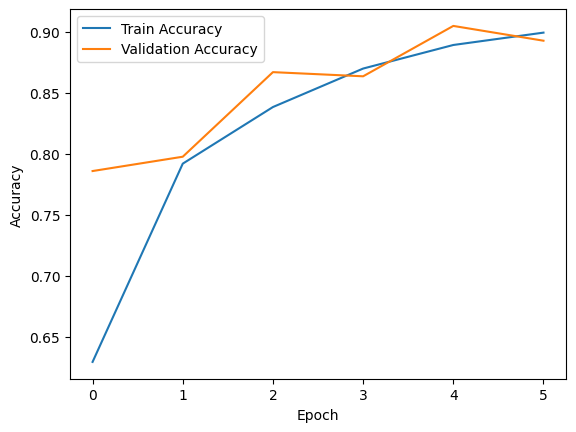

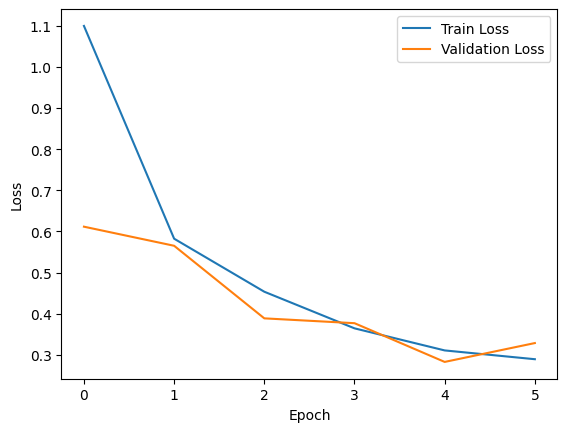

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./whichSpeed_dataset_test/',
    image_size=(im_height, im_width),
    batch_size=batch_size,
    shuffle=False  # Shuffle can be disabled for testing to maintain order
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 13200 files belonging to 9 classes.


In [5]:
model = tf.keras.models.load_model('./models/best_whichSpeed_model.keras')

In [6]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

413/413 ━━━━━━━━━━━━━━━━━━━━ 363s 878ms/step - accuracy: 0.9621 - loss: 0.1121
Test Accuracy: 0.95


In [7]:
# Mapping from class number to actual sign label
mapping = {
    0: "20",
    1: "30",
    2: "50",
    3: "60",
    4: "70",
    5: "80",
    6: "End Of Limit",
    7: "100",
    8: "120",
}

In [8]:
# Gather true labels from the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Generate prediction probabilities using the model
y_pred_probs = model.predict(test_ds)

# Convert prediction probabilities to predicted class labels (using argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

413/413 ━━━━━━━━━━━━━━━━━━━━ 387s 937ms/step


Confusion Matrix:
[[ 206    4    0    0    0    0    0    0    0]
 [   0 2165   21    4   20    1    0    4    5]
 [   1   47 2139   16   23    5    0    5   14]
 [   0    9    7 1334   33   13    1    3   10]
 [   0    6    4    0 1944    2    0    0   24]
 [   0   14   24   13    9 1702    0    6   92]
 [   0    0    0    1    0    1  418    0    0]
 [   0    1    0    0   21   19    0 1257  142]
 [   0    0    1    0   30    8    0    1 1370]]

Classification Report:
              precision    recall  f1-score   support

          20       1.00      0.98      0.99       210
          30       0.96      0.98      0.97      2220
          50       0.97      0.95      0.96      2250
          60       0.98      0.95      0.96      1410
          70       0.93      0.98      0.96      1980
          80       0.97      0.92      0.94      1860
End Of Limit       1.00      1.00      1.00       420
         100       0.99      0.87      0.93      1440
         120       0.83      0.97     

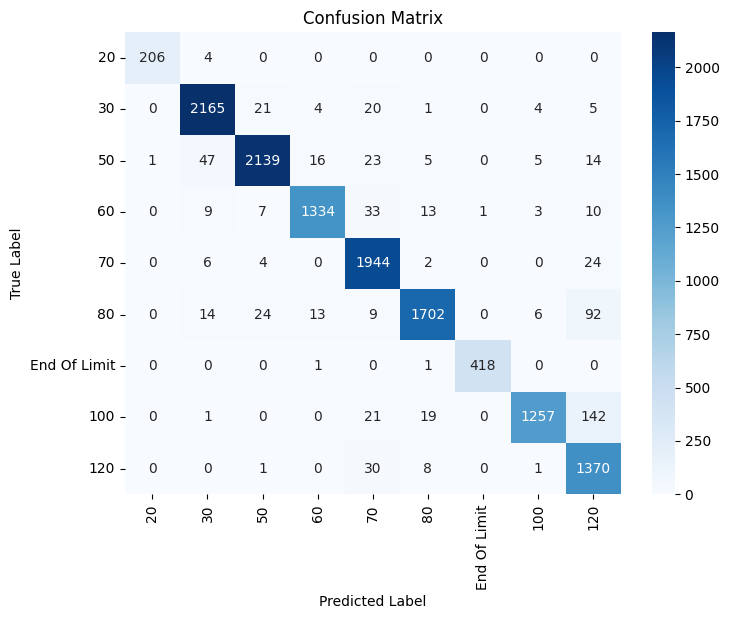

In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

target_names = [mapping[i] for i in range(9)]

# Print a classification report with the mapped class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Predicted sign: 50


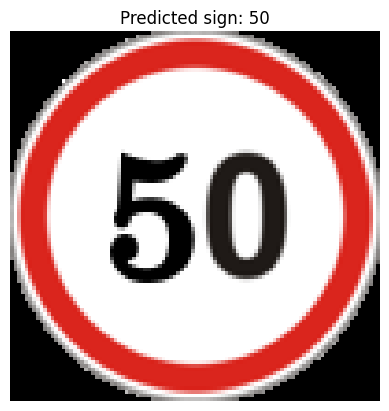

In [10]:
# Path to image file
img_path = "./gtsrb-german-traffic-sign/versions/1/Meta/2.png"  

# Load the image and resize it
img = image.load_img(img_path, target_size=(im_height, im_width))
img_array = image.img_to_array(img)

# Normalize the image to [0, 1]
img_array = img_array / 255.0

# Add a batch dimension (model expects a batch of images)
img_batch = np.expand_dims(img_array, axis=0)

# Make prediction
prediction_probs = model.predict(img_batch)[0]  # shape should be (9,) for 9 classes

# Convert prediction probabilities to a predicted class label using argmax
predicted_class = np.argmax(prediction_probs)
predicted_sign = mapping[predicted_class]
print("Predicted sign:", predicted_sign)
result = f"Predicted sign: {predicted_sign}"

# Display the image with the prediction result
plt.imshow(img)
plt.title(result)
plt.axis("off")
plt.show()